In [ ]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from unet.data import load_data
from unet.train import calculate_iou

In [5]:
# Load the trained model
model = smp.Unet(
    encoder_name="mobilenet_v2",  # Example encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=4,  # Adjust number of classes
)
model.load_state_dict(torch.load('unet/trained_model.pth'))
model.eval()

C:\Users\vedan\AppData\Local\Temp\ipykernel_31372\624393811.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet/trained_model.pth'))


Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [6]:
def calculate_ious(predictions, targets):
# Calculate IoU for each category
    head_iou = calculate_iou(predictions, targets, class_value=1)
    flipper_iou = calculate_iou(predictions, targets, class_value=2)
    carapace_iou = calculate_iou(predictions, targets, class_value=3)

    print("head: ", head_iou)
    print("flippers: ", flipper_iou)
    print("carapace: ", carapace_iou)


In [7]:
def display_results(input_image, output_mask, ground_truth_mask):
    plt.figure(figsize=(15, 5))

    # Display the original input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Original Image")

    # Display the segmentation mask output
    plt.subplot(1, 3, 2)
    plt.imshow(output_mask)
    plt.title("Segmentation Mask")

    # Display the ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask)
    plt.title("Ground Truth Mask")

    plt.show()

In [9]:
# Define function to predict and visualize the output
def predict(model, test_loader, num_images=5):  
    # Create a list to store random images and labels from the test_loader
    random_images = []
    
    # Extract all batches and pick random images until we get `num_images`
    for batch in test_loader:
        data, targets = batch
        for i in range(len(data)):
            if len(random_images) < num_images:
                random_images.append((data[i], targets[i]))
            else:
                break  # Stop once we have enough images
    
    # Process each selected image
    with torch.no_grad():
        for data, target in random_images:
            # Prepare image for model input
            data = data.unsqueeze(0)  # Add batch dimension
            output = model(data)  # Run the model
            prediction = torch.argmax(output, dim=1)
            
            # Move tensors to CPU for display
            target_np = target.cpu().numpy() 
            data_np = data.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to [H, W, C]
            prediction_np = prediction.squeeze(0).cpu().numpy()
            
            # Display results
            calculate_ious(prediction, target.unsqueeze(0))  # Assuming calculate_ious can handle single tensors
            display_results(data_np, prediction_np, target_np)  

loading annotations into memory...
Done (t=3.04s)
creating index...
index created!
loading annotations into memory...
Done (t=3.07s)
creating index...
index created!
loading annotations into memory...
Done (t=3.16s)
creating index...
index created!
head:  tensor(0.9777)
flippers:  tensor(0.9161)
carapace:  tensor(0.9172)


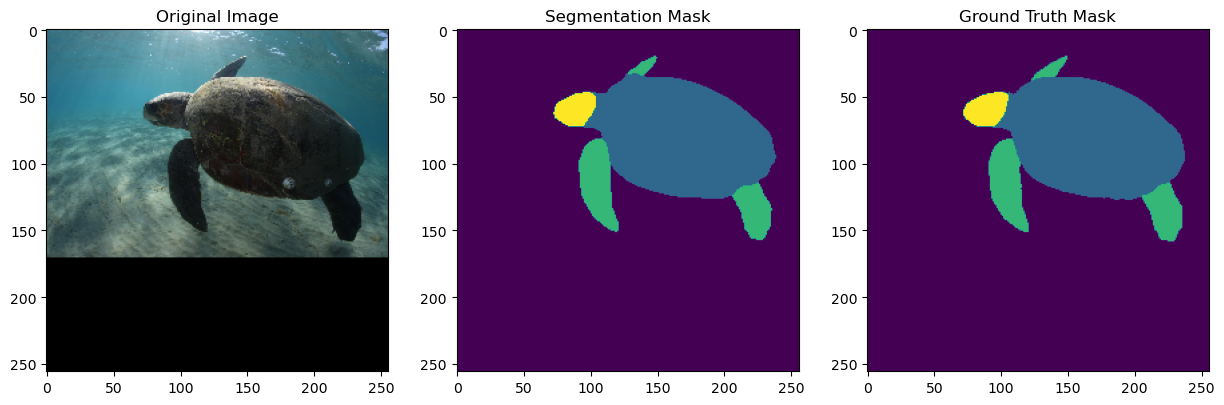

head:  tensor(0.8859)
flippers:  tensor(0.8366)
carapace:  tensor(0.8956)


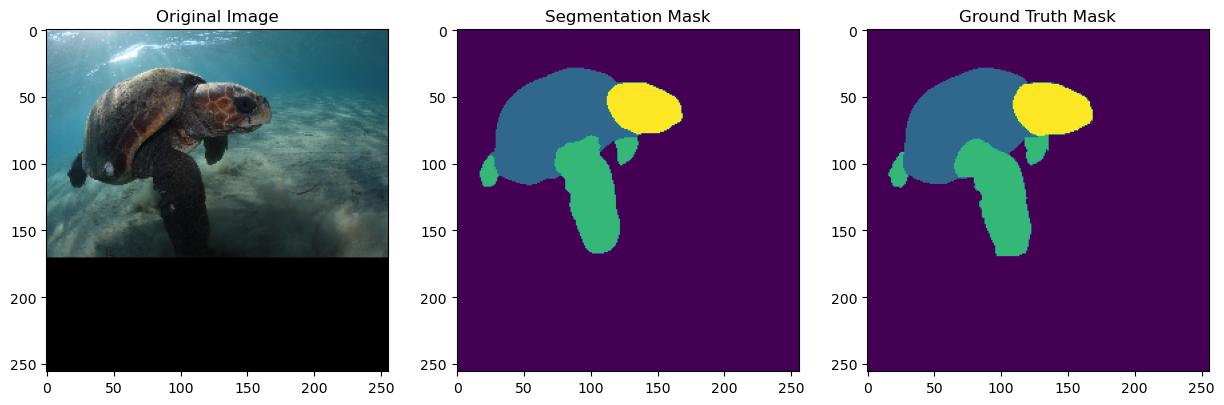

head:  tensor(0.4071)
flippers:  tensor(0.4872)
carapace:  tensor(0.1850)


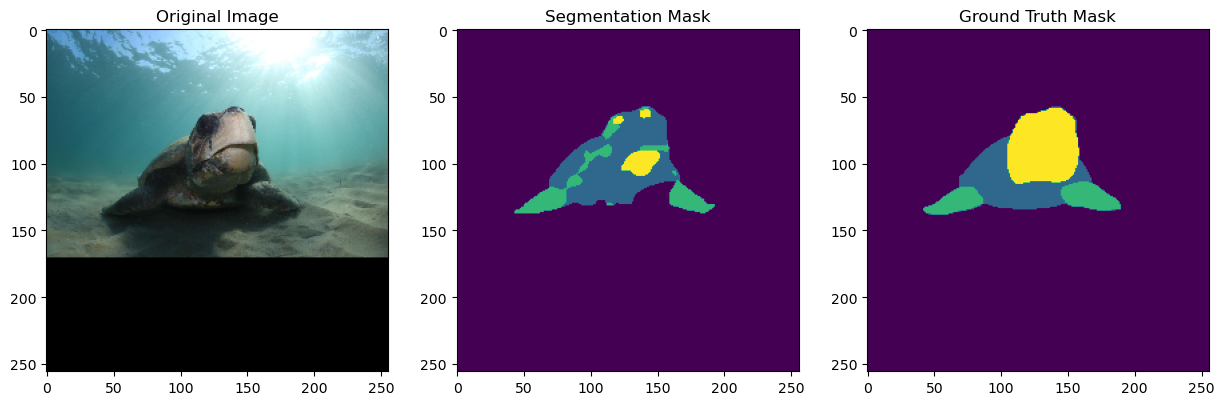

head:  tensor(0.9442)
flippers:  tensor(0.8313)
carapace:  tensor(0.8746)


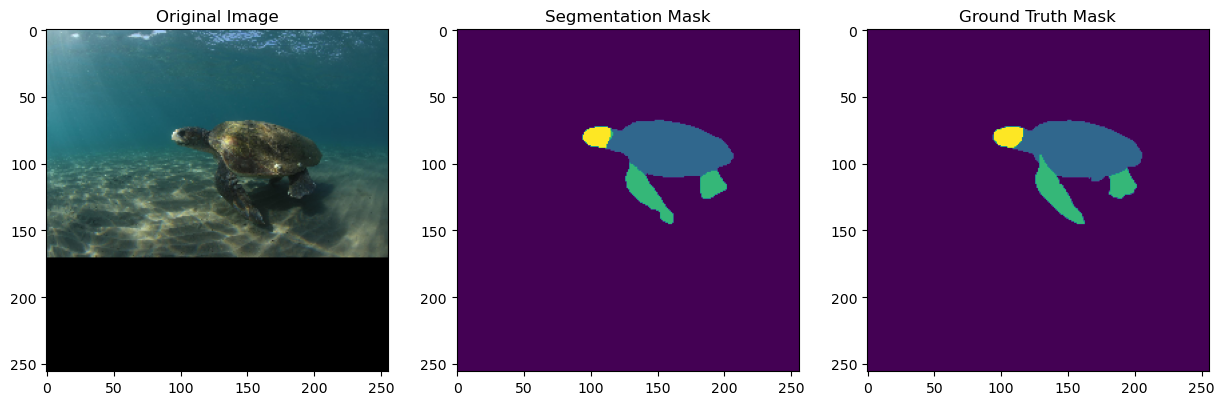

head:  tensor(0.9071)
flippers:  tensor(0.7662)
carapace:  tensor(0.8928)


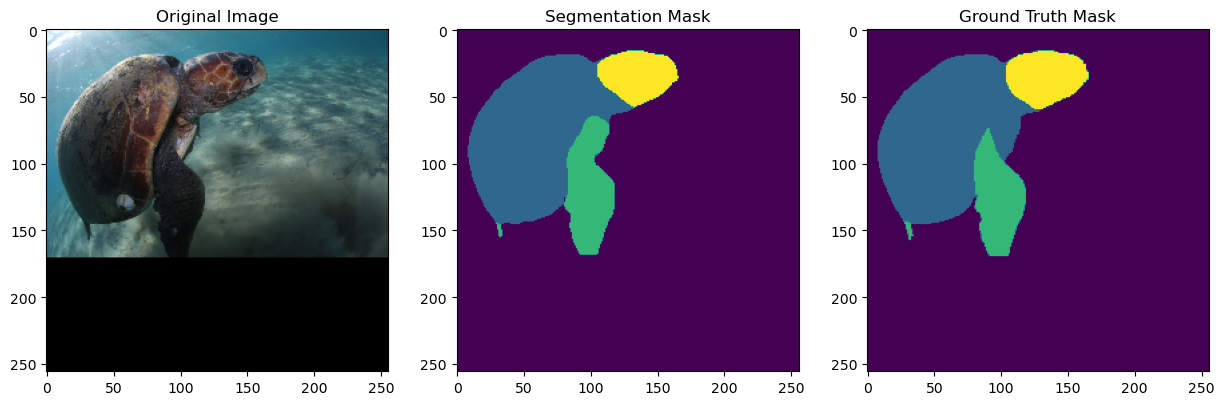

In [10]:
# Run an example
_, _, test_loader = load_data(r"C:\Users\vedan\Desktop\COMP9517\COMP9517 group project\turtles-data\data\images")
predict(model, test_loader, 5)